# Explanation of the FiniteElementVary2DMeshConstructor
This file presents a step-by-step application of the `sfsimodels.num.mesh.FiniteElementVary2DMeshConstructor`
to an `sfsimodels.TwoDSystem`.

## Import python libraries for displaying images

In [1]:
%gui qt5
from PyQt5.Qt import QApplication
import pyqtgraph as pg
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import sfsimodels as sm
from sfsimodels.num import mesh
import numpy as np
import o3plot
import pyqtgraph.exporters

# start qt event loop
_instance = QApplication.instance()
if not _instance:
    _instance = QApplication([])
app = _instance

## Define a two dimensional system
The system consists of two soil profiles with angled layers, a surface ground slope and a
building with an embedded foundation.

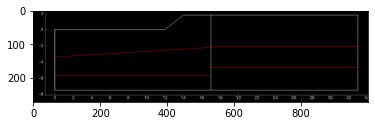

In [9]:
vs = 150.0
rho = 1.8
g_mod = vs ** 2 * rho

sl1 = sm.Soil(g_mod=g_mod, unit_dry_weight=rho * 9.8, poissons_ratio=0.32)
sl2 = sm.Soil(g_mod=g_mod, unit_dry_weight=rho * 9.8, poissons_ratio=0.33)
sl3 = sm.Soil(g_mod=g_mod, unit_dry_weight=rho * 9.8, poissons_ratio=0.34)
sl4 = sm.Soil(g_mod=g_mod, unit_dry_weight=rho * 9.8, poissons_ratio=0.35)
sl5 = sm.Soil(g_mod=g_mod, unit_dry_weight=rho * 9.8, poissons_ratio=0.36)
sp = sm.SoilProfile()
h_face = 1.8
sp.add_layer(0, sl1)
sp.add_layer(3.4, sl2)
sp.add_layer(5.7, sl3)
sp2 = sm.SoilProfile()
sp2.add_layer(0, sl4)
sp2.add_layer(3.9, sl2)
sp2.add_layer(6.5, sl5)
sp2.height = 20
sp.x_angles = [None, 0.07, 0.0]
sp2.x_angles = [None, 0.00, 0.0]

# fd = sm.RaftFoundation()
# fd.width = 3
# fd.depth = 0.6
# fd.ip_axis = 'width'
# fd.height = 0.7
# fd.length = 100
tds = sm.TwoDSystem(width=33, height=7.5)
tds.add_sp(sp, x=0)
tds.add_sp(sp2, x=17)
tds.x_surf = np.array([0, 12, 14, tds.width])
tds.y_surf = np.array([0, 0, h_face, h_face])
# bd = sm.NullBuilding()
# bd.set_foundation(fd, x=0.0)
# tds.add_bd(bd, x=22)

x_scale_pos = np.array([0, 5, 10, 16, 19, 25, 29])
x_scale_vals = np.array([2., 1.2, 1.0, 1.2, 0.7, 1.2, 2])
win = o3plot.create_scaled_window_for_tds(tds, title='ECP definition')
o3plot.plot_two_d_system(tds, win)
exp = pyqtgraph.exporters.ImageExporter(win.plotItem)
exp.export('', toBytes=True)
imshow(exp.bg)
plt.show()

## Initialise the constructor
The constructor is given two primary inputs:
 - `tds`: an `sfsimodels.TwoDSystem`, A Two dimensional system defined using the sfsimodels `TwoDSystem` object.
 - `dy_target`: `float` which defines the target height of each element

There are also five optional mesh control inputs.

 - `x_scale_pos`: `array_like`, defining positions from the left edge, where the element width should change size, default to [0.0]
 - `x_scale_vals`: `array_like`, defining the scale between the target element height and target element width at
 each zone between the `x_scale_pos` points, defaults to [1.0]
 - `min_scale` The target minimum mesh ratio of the target (`dy_target`), default = 0.5
 - `max_scale` The target maximum mesh ratio of the target (`dy_target`), default = 2.0
 - `allowable_slope` The target change in height over width across a set of blocks before an block should be added/remove, default = 0.25


The `auto_run` parameter is also set to `False` to allow each step to be run individually.

In [10]:
# Initial the constructor
fc = mesh.mesh2d_vary_y.FiniteElementVary2DMeshConstructor(tds, dy_target=0.5, x_scale_pos=x_scale_pos,
                                                           x_scale_vals=x_scale_vals, auto_run=False, min_scale=0.5,
                                                           max_scale=2, allowable_slope=0.25)

## Step 1: Find the important coordinates and slopes in the 2D system
This includes layer boundaries, foundation corners, and surface slopes that should be
maintained in the FE mesh. When coordinates are very close (less than `min_scale*dy_target`) then the top left coordinate is kept.

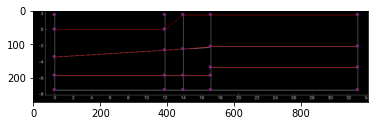

In [17]:
fc.get_special_coords_and_slopes()

# plot the model state
win = o3plot.create_scaled_window_for_tds(tds, title='get_special_coords_and_slopes')
y_sps_surf = np.interp(tds.x_sps, tds.x_surf, tds.y_surf)
for i in range(len(tds.sps)):
    x0 = tds.x_sps[i]
    if i == len(tds.sps) - 1:
        x1 = tds.width
    else:
        x1 = tds.x_sps[i + 1]
    xs = np.array([x0, x1])
    x_angles = list(tds.sps[i].x_angles)
    sp = tds.sps[i]
    for ll in range(1, sp.n_layers + 1):
        if x_angles[ll - 1] is not None:
            ys = y_sps_surf[i] - sp.layer_depth(ll) + x_angles[ll - 1] * (xs - x0)
            win.plot(xs, ys, pen='w')
for i in range(len(fc.sds)):
    win.plot(fc.sds[i][0], fc.sds[i][1], pen='b')
win.plot([0, fc.tds.width], [-fc.tds.height, -fc.tds.height], pen='w')
xcs = fc.xcs_sorted
for i in range(len(xcs)):
    xc = xcs[i]
    xn = xc * np.ones_like(list(fc.yd[xc]))
    win.plot(xn, list(fc.yd[xc]), symbol='o', symbolPen='r')
exp = pyqtgraph.exporters.ImageExporter(win.plotItem)
exp.export('', toBytes=True)
imshow(exp.bg)
plt.show()

## Step 2: Set the initial number of elements along important x-lines
Estimate the number of elements high at each important coordinate based on the `dy_target`.


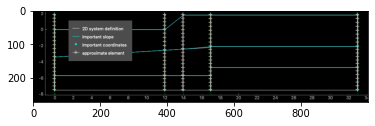

In [18]:
fc.set_init_y_blocks()
win = o3plot.create_scaled_window_for_tds(tds, title='set_init_y_blocks')
leg = win.addLegend(offset=(70, 30), brush=0.3, labelTextColor='w')
o3plot.plot_two_d_system(tds, win, c2='w', cs='w')
leg.addItem(pg.PlotDataItem([0], [0], pen='w'), name='2D system definition')
for i in range(len(fc.sds)):
    win.plot(fc.sds[i][0], fc.sds[i][1], pen='y', name='Important slope')
xcs = fc.xcs_sorted
for i in range(len(xcs)):
    xc = xcs[i]
    h_blocks = np.diff(fc.yd[xc])
    dhs = h_blocks / fc.y_blocks[xc]
    y_node_steps = [0]
    for hh in range(len(fc.y_blocks[xc])):
        y_node_steps += [dhs[hh] for u in range(fc.y_blocks[xc][hh])]
    y_node_coords = np.cumsum(y_node_steps) - tds.height
    xn = xc * np.ones_like(list(fc.yd[xc]))
    win.plot(xn, list(fc.yd[xc]), symbol='o', symbolPen='y', symbolBrush='y', symbolSize=5, pen=None, name='Important coordinates')
    xn = xc * np.ones_like(y_node_coords)
    win.plot(xn, y_node_coords, symbol='+', name='approximate element')
    win.addItem(pg.InfiniteLine(xcs[i], angle=90, pen=(0, 255, 0, 100)))
o3plot.revamp_legend(leg)
exp = pyqtgraph.exporters.ImageExporter(win.plotItem)
exp.export('', toBytes=True)
imshow(exp.bg)
plt.show()


## Step 3: Adjust the number of blocks high to try to have the same number of blocks along each slope
Moving from left to right, then bottom to top, try to make the number of blocks along a slope even
by checking if a elements can be added or subtracted from the right side of the slope.


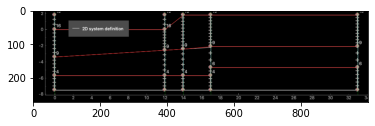

In [19]:
fc.adjust_blocks_to_be_consistent_with_slopes()
win = o3plot.create_scaled_window_for_tds(tds, title='adjust_blocks_to_be_consistent_with_slopes')
leg = win.addLegend(offset=(70, 30), brush=0.3, labelTextColor='w')
o3plot.plot_two_d_system(tds, win, c2='w', cs='w')
leg.addItem(pg.PlotDataItem([0], [0], pen='w'), name='2D system definition')
for i in range(len(fc.sds)):
    win.plot(fc.sds[i][0], fc.sds[i][1], pen='b')
win.plot([0, fc.tds.width], [-fc.tds.height, -fc.tds.height], pen='w')
xcs = fc.xcs_sorted
for i in range(len(xcs)):
    xc = xcs[i]
    h_blocks = np.diff(fc.yd[xc])
    dhs = h_blocks / fc.y_blocks[xc]
    y_node_steps = [0]
    for hh in range(len(fc.y_blocks[xc])):
        y_node_steps += [dhs[hh] for u in range(fc.y_blocks[xc][hh])]
    y_node_coords = np.cumsum(y_node_steps) - tds.height
    xn = xc * np.ones_like(list(fc.yd[xc]))
    win.plot(xn, list(fc.yd[xc]), symbol='o', pen='r')
    nbs = np.cumsum(fc.y_blocks[xc])
    for cc in range(len(fc.y_blocks[xc])):
        text = pg.TextItem(f'{nbs[cc]}', anchor=(0, 1))
        win.addItem(text)
        text.setPos(xc, fc.yd[xc][cc+1])
    xn = xc * np.ones_like(y_node_coords)
    win.plot(xn, y_node_coords, symbol='+')
    win.addItem(pg.InfiniteLine(xcs[i], angle=90, pen=(0, 255, 0, 100)))
o3plot.revamp_legend(leg)
exp = pyqtgraph.exporters.ImageExporter(win.plotItem)
exp.export('', toBytes=True)
imshow(exp.bg)
plt.show()

## Adjust the number of blocks to try to eliminate large and small elements

 1. Cycle through all zones (vertical space between two important coordinates), compute the average element height.
 2. For the smallest element if it is less than the target size (`dy_target`), then try to remove a row of elements,
    compute the new average block height for each zone at the same height if an element is removed, if the new block
    height does not exceed the optimally upper limit (`dy_target * (max_scale + 1) / 2`), then remove a row of elements
    at that height. If an element can not be removed without exceeding the limits, then move to the next smallest.
    Repeat until no more blocks can be removed.
 3. Repeat similar to step 2, but trying to reduce the size of larger blocks. For the largest element if it is greater than
   the optimally upper limit size, then try to add a row of elements, compute the new
   average block height for each zone at the same height if an element is added, if the new block height is not
    less the optimally lower limit (`dy_target * (min_scale + 1) / 2`), then add a row of elements at that height.
    Repeat until no more blocks can be added.


/Users/maximmillen/git/packages/sfsimodels/sfsimodels/num/mesh/mesh2d_vary_y.py:452: RuntimeWarning: divide by zero encountered in double_scalars
  new_dh = hzone / (nb_high - nb_low - 1)


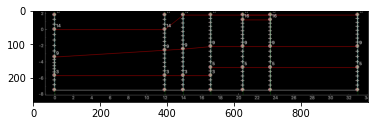

In [7]:
fc.trim_grid_to_target_dh()
win = o3plot.create_scaled_window_for_tds(tds, title='trim_grid_to_target_dh')
for i in range(len(fc.sds)):
    win.plot(fc.sds[i][0], fc.sds[i][1], pen='b')
win.plot([0, fc.tds.width], [-fc.tds.height, -fc.tds.height], pen='w')
xcs = fc.xcs_sorted
for i in range(len(xcs)):
    xc = xcs[i]
    h_blocks = np.diff(fc.yd[xc])
    dhs = h_blocks / fc.y_blocks[xc]
    y_node_steps = [0]
    for hh in range(len(fc.y_blocks[xc])):
        y_node_steps += [dhs[hh] for u in range(fc.y_blocks[xc][hh])]
    y_node_coords = np.cumsum(y_node_steps) - tds.height
    xn = xc * np.ones_like(list(fc.yd[xc]))
    win.plot(xn, list(fc.yd[xc]), symbol='o', pen='r')
    nbs = np.cumsum(fc.y_blocks[xc])
    for cc in range(len(fc.y_blocks[xc])):
        text = pg.TextItem(f'{nbs[cc]}', anchor=(0, 1))
        win.addItem(text)
        text.setPos(xc, fc.yd[xc][cc + 1])
    xn = xc * np.ones_like(y_node_coords)
    win.plot(xn, y_node_coords, symbol='+')
    win.addItem(pg.InfiniteLine(xcs[i], angle=90, pen=(0, 255, 0, 100)))
exp = pyqtgraph.exporters.ImageExporter(win.plotItem)
exp.export('', toBytes=True)
imshow(exp.bg)
plt.show()

## Finalise the number of elements in each zone

Establish additional important coordinates where there is a steep change in slope.

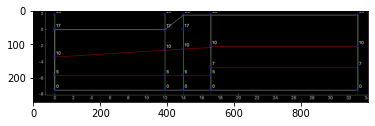

In [31]:
fc.build_req_y_node_positions()
win = o3plot.create_scaled_window_for_tds(tds, title='build_req_y_node_positions')
o3plot.plot_two_d_system(tds, win)
xcs = fc.xcs_sorted
for i in range(len(xcs)):
    xc = xcs[i]
    h_blocks = np.diff(fc.yd[xc])
    dhs = h_blocks / fc.y_blocks[xc]
    y_node_steps = [0]
    for hh in range(len(fc.y_blocks[xc])):
        y_node_steps += [dhs[hh] for u in range(fc.y_blocks[xc][hh])]
    y_node_coords = np.cumsum(y_node_steps) - tds.height

    xn = xc * np.ones_like(list(fc.req_y_coords_at_xcs[i]))
    win.plot(xn, list(fc.req_y_coords_at_xcs[i]), symbol='x', symbolPen='r')
    win.addItem(pg.InfiniteLine(xcs[i], angle=90, pen=(0, 255, 0, 100)))
    nbs = fc.req_y_nodes[i]
    for cc in range(len(fc.req_y_nodes[i])):
        text = pg.TextItem(f'{nbs[cc]}', anchor=(0, 1))
        win.addItem(text)
        text.setPos(xc, fc.req_y_coords_at_xcs[i][cc])
exp = pyqtgraph.exporters.ImageExporter(win.plotItem)
exp.export('', toBytes=True)
imshow(exp.bg)
plt.show()

## Build y-coordinates at xcs
Create the y-coordinates for each node along each significant vertical line

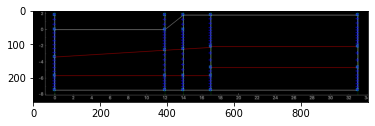

In [33]:
fc.build_y_coords_at_xcs()
win = o3plot.create_scaled_window_for_tds(tds, title='build_y_coords_at_xcs')
o3plot.plot_two_d_system(tds, win)
xcs = fc.xcs_sorted
for i in range(len(xcs)):
    xc = xcs[i]
    h_blocks = np.diff(fc.yd[xc])
    dhs = h_blocks / fc.y_blocks[xc]
    y_node_steps = [0]
    for hh in range(len(fc.y_blocks[xc])):
        y_node_steps += [dhs[hh] for u in range(fc.y_blocks[xc][hh])]
    y_node_coords = np.cumsum(y_node_steps) - tds.height
    xn = xc * np.ones_like(list(fc.req_y_coords_at_xcs[i]))
    win.plot(xn, list(fc.req_y_coords_at_xcs[i]), symbol='x', symbolPen='y')
    xn = xc * np.ones_like(list(fc.y_coords_at_xcs[i]))
    win.plot(xn, list(fc.y_coords_at_xcs[i]), symbol='+', symbolPen='r')
    win.addItem(pg.InfiniteLine(xcs[i], angle=90, pen=(0, 255, 0, 100)))
exp = pyqtgraph.exporters.ImageExporter(win.plotItem)
exp.export('', toBytes=True)
imshow(exp.bg)
plt.show()



## Set the x position of the nodes

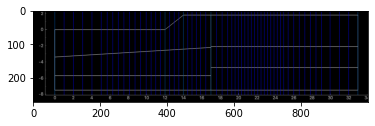

In [34]:
fc.set_x_nodes()
win = o3plot.create_scaled_window_for_tds(tds, title='set_x_nodes')
o3plot.plot_two_d_system(tds, win, c2='w', cs='w')
for i in range(len(fc.x_nodes)):
    win.addItem(pg.InfiniteLine(fc.x_nodes[i], angle=90, pen='r'))
for i in range(len(fc.xcs_sorted)):
    win.addItem(pg.InfiniteLine(fc.xcs_sorted[i], angle=90, pen=(0, 255, 0, 100)))
exp = pyqtgraph.exporters.ImageExporter(win.plotItem)
exp.export('', toBytes=True)
imshow(exp.bg)
plt.show()

## Determine the y-coordinates of each node by propagating the position of the y-coordinates from left to right.

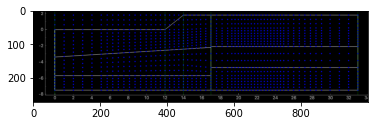

In [35]:
fc.build_y_coords_grid_via_propagation()
win = o3plot.create_scaled_window_for_tds(tds, title='build_y_coords_grid_via_propagation')
o3plot.plot_two_d_system(tds, win, c2='w', cs='w')
xns = fc.x_nodes
for i in range(len(xns)):
    xc = xns[i]
    xn = xc * np.ones_like(fc.y_nodes[i])
    win.plot(xn, fc.y_nodes[i], pen=None, symbol='o', symbolPen='r', symbolBrush='r', symbolSize=3)
for i in range(len(fc.xcs_sorted)):
    win.addItem(pg.InfiniteLine(fc.xcs_sorted[i], angle=90, pen=(0, 255, 0, 100)))
exp = pyqtgraph.exporters.ImageExporter(win.plotItem)
exp.export('', toBytes=True)
imshow(exp.bg)
plt.show()


## Set the coordinates to nearest decimal points

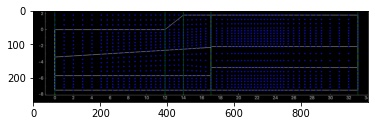

In [36]:
win = o3plot.create_scaled_window_for_tds(tds, title='set_to_decimal_places')
o3plot.plot_two_d_system(tds, win, c2='w', cs='w')
xns = fc.x_nodes
for i in range(len(xns)):
    xc = xns[i]
    xn = xc * np.ones_like(fc.y_nodes[i])
    win.plot(xn, fc.y_nodes[i], pen=None, symbol='o', symbolPen=0.5, symbolBrush=0.5, symbolSize=3)
for i in range(len(fc.xcs_sorted)):
    win.addItem(pg.InfiniteLine(fc.xcs_sorted[i], angle=90, pen=(0, 255, 0, 100)))
fc.dp = 2
fc.set_to_decimal_places()
xns = fc.x_nodes
for i in range(len(xns)):
    xc = xns[i]
    xn = xc * np.ones_like(fc.y_nodes[i])
    win.plot(xn, fc.y_nodes[i], pen=None, symbol='o', symbolPen='r', symbolBrush='r', symbolSize=3)
for i in range(len(fc.xcs_sorted)):
    win.addItem(pg.InfiniteLine(fc.xcs_sorted[i], angle=90, pen=(0, 255, 0, 100)))
exp = pyqtgraph.exporters.ImageExporter(win.plotItem)
exp.export('', toBytes=True)
imshow(exp.bg)
plt.show()


## Smooth the surface

Adjust the x-coordinates of the nodes near the surface to make sure that there are no
orthogonal sets of coordinates.
If the number of elements in the x-direction is less than the number of elements in the y-direction between two
important coordinates, then make the slope smooth, else use a series of sloped steps.

In [ ]:
fc.adjust_for_smooth_surface()
win = o3plot.create_scaled_window_for_tds(tds, title='build_y_coords_grid_via_propagation')
for i in range(len(fc.sds)):
    win.plot(fc.sds[i][0], fc.sds[i][1], pen='b')
win.plot([0, fc.tds.width], [-fc.tds.height, -fc.tds.height], pen='w')
xns = fc.x_nodes
for i in range(len(xns)):
    xc = xns[i]
    xn = xc * np.ones_like(fc.y_nodes[i])
    win.plot(xn, fc.y_nodes[i], pen=None, symbol='o', symbolPen='r', symbolBrush='r', symbolSize=3)
for i in range(len(fc.xcs_sorted)):
    win.addItem(pg.InfiniteLine(fc.xcs_sorted[i], angle=90, pen=(0, 255, 0, 100)))
o3plot.show()


## Create a mesh of elements with the soil ids
The null elements are set to inactive.

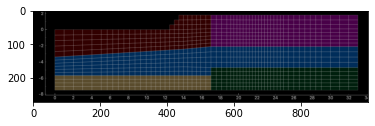

In [19]:
fc.set_soil_ids_to_grid()
fc.create_mesh()
win = o3plot.create_scaled_window_for_tds(tds, title='set_soil_ids_to_grid')
o3plot.plot_finite_element_mesh_onto_win(win, fc.femesh)
exp = pyqtgraph.exporters.ImageExporter(win.plotItem)
exp.export('', toBytes=True)
imshow(exp.bg)
plt.show()


## Remove Foundation elements
Can chose to set the foundation elements to inactive.

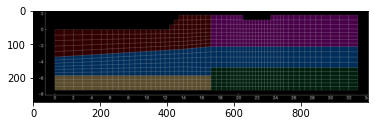

In [20]:
fc.exclude_fd_eles()
win = o3plot.create_scaled_window_for_tds(tds, title='exclude_fd_eles')
o3plot.plot_finite_element_mesh_onto_win(win, fc.femesh)
exp = pyqtgraph.exporters.ImageExporter(win.plotItem)
exp.export('', toBytes=True)
imshow(exp.bg)
plt.show()